In [19]:
# ! pip install pandas
# ! pip install numpy
# ! pip install seaborn
# ! pip install matplotlib
# ! pip install scikit_learn
# ! pip install rdatasets

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import load_wine
from rdatasets import data


In [21]:
# DS 1
wine_data = load_wine()
wine_df = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
wine_df["target"] = wine_data.target

# DS 2
chickwts = data("chickwts").dropna()

# DS 3
usarrests = data("USArrests").dropna()

# Display DS similarities
print("Wine Dataset:\n", wine_df.head(), "\n")
print("Chickwts Dataset:\n", chickwts.head(), "\n")
print("USArrests Dataset:\n", usarrests.head(), "\n")




Wine Dataset:
    alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  targe

In [22]:
wine_df["target"] = wine_df["target"].astype("category").cat.codes

X = wine_df.drop(columns=["target"])
y = wine_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

param_grid = {'n_neighbors': range(1,21), 'metric': ['euclidean', 'manhattan', 'minkowski']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
print(f"Best k: {best_k}, Best Distance Metric: {best_metric}")

knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)

print("k-NN Classification Report:\n", classification_report(y_test, y_pred))
print(f"k-NN Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Best k: 20, Best Distance Metric: euclidean
k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.93      0.96        14
           2       1.00      1.00      1.00         8

    accuracy                           0.97        36
   macro avg       0.98      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36

k-NN Accuracy: 0.97


In [23]:
scaler = StandardScaler()
chickwts_scaled = scaler.fit_transform(chickwts[["weight"]])

pca == PCA(n_components=1)
chickwts_pca = pca.fit_transform(chickwts_scaled)

similarity_matrix = cosine_similarity(chickwts_pca)


def recommend_feeds(feed_name, num_recommendations=3):
    feed_index = chickwts.index[chickwts["feed"] == feed_name].tolist()[0]
    similarity_scores = list(enumerate(similarity_matrix[feed_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    recommend_feeds = [chickwts.iloc[i]["feed"] for i, score in similarity_scores[1:num_recommendations+1]]
    return recommend_feeds

print("Recommended feeds for 'soybean':", recommend_feeds("soybean"))



Recommended feeds for 'soybean': ['horsebean', 'horsebean', 'horsebean']


Besty number of clusters for K-Means: 10


c:\Users\ronjo\Documents\Flatiron\Week4\Lab\venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


Best number of clusters for GMM: 1


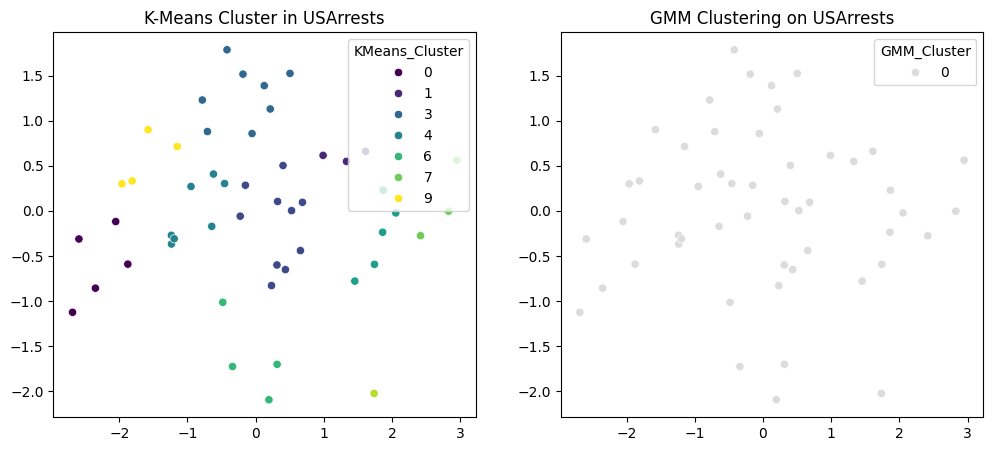

In [24]:
scaler = StandardScaler()
usarrests_scaled = scaler.fit_transform(usarrests.iloc[:, 1:])

selector = SelectKBest(score_func=f_classif, k=3)
usarrests_selected = selector.fit_transform(usarrests_scaled, usarrests.index)

pca = PCA(n_components=2)
usarrests_pca = pca.fit_transform(usarrests_selected)

inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(usarrests_pca)
    inertia.append(kmeans.inertia_)

best_k = inertia.index(min(inertia[1:])) + 1
print(f"Besty number of clusters for K-Means: {best_k}")


kmeans = KMeans(n_clusters=best_k, random_state=42)
usarrests["KMeans_Cluster"] = kmeans.fit_predict(usarrests_pca)

best_gmm_k = 1
lowest_bic = np.inf
for k in range(1,11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(usarrests_pca)
    bic=gmm.bic(usarrests_pca)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm_k = k

print(f"Best number of clusters for GMM: {best_gmm_k}")


gmm = GaussianMixture(n_components=best_gmm_k, random_state=42)
usarrests["GMM_Cluster"] = gmm.fit_predict(usarrests_pca)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.scatterplot(x=usarrests_pca[:, 0], y=usarrests_pca[:, 1], hue=usarrests["KMeans_Cluster"], palette="viridis")
plt.title("K-Means Cluster in USArrests")

plt.subplot(1,2,2)
sns.scatterplot(x=usarrests_pca[:,0], y=usarrests_pca[:,1], hue=usarrests["GMM_Cluster"], palette="coolwarm")
plt.title("GMM Clustering on USArrests")
plt.show()




